In [150]:
%pip install scikit-learn-extra -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\slesh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import CLARA
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 1 

Разбейте множество объектов из набора данных pluton в пакете «cluster» на 3 кластера методом центров тяжести (kmeans). Сравните качество разбиения в зависимости от максимального числа итераций алгоритма.

In [19]:
data = pd.read_csv("pluton.csv")
data = data.drop("rownames", axis=1)
data.head()

,Pu238,Pu239,Pu240,Pu241
0,0.126,75.804,21.204,2.180
1,0.133,75.515,21.408,2.240
2,0.127,75.175,21.668,2.305
3,0.156,78.872,18.428,1.906
4,0.503,73.317,20.223,4.128


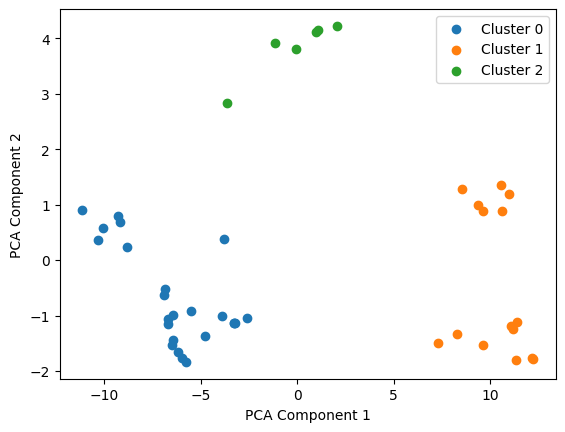

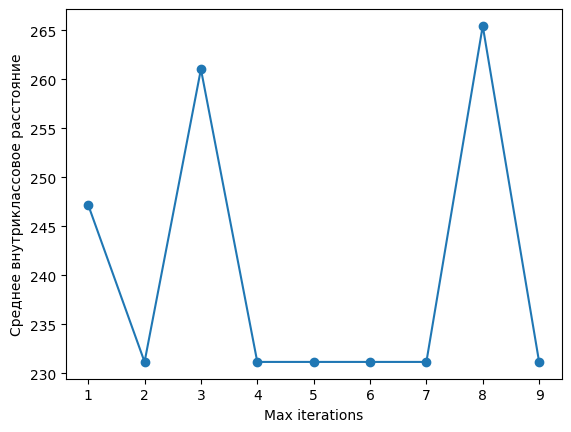

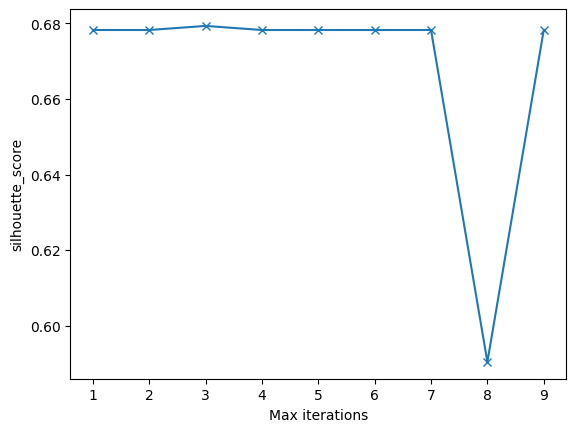

In [34]:
X = data.values

inertia_values = []
silhouette_values = []
max_iterations = [i for i in range(1, 10)]

for max_iter in max_iterations:

    kmeans = KMeans(n_clusters=3, max_iter=max_iter, tol=0, init='random', n_init=3)

    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X, labels = kmeans.labels_))

data['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data.drop('cluster', axis=1))
for cluster in range(3):
    cluster_data = reduced_data[data['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.savefig('pluto_pca.png')
plt.show()



plt.plot(max_iterations, inertia_values, marker='o')
plt.xlabel('Max iterations')
plt.ylabel('Среднее внутриклассовое расстояние')
plt.savefig("max_iters_inertia.png", dpi=300)
plt.show()

plt.plot(max_iterations, silhouette_values, marker='x')
plt.xlabel('Max iterations')
plt.ylabel('silhouette_score')
plt.show()

In [23]:
inertia_values

[486.1567956715882,
 253.46507513888878,
 499.13760786666677,
 488.6210362681993,
 239.46082221333336,
 235.67466762499996,
 360.7015020833334,
 253.46507513888878,
 235.67466762499996]

# 2	
Сгенерируйте набор данных в двумерном пространстве, состоящий из 3 кластеров, каждый из которых сильно “вытянут” вдоль одной из осей. Исследуйте качество кластеризации методом clara в зависимости от 1) использования стандартизации; 2) типа метрики. Объясните полученные результаты.

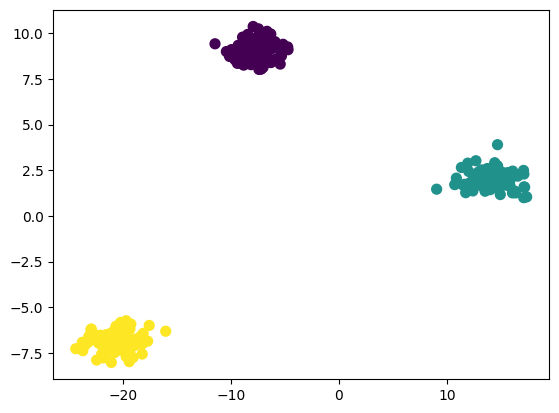

In [204]:
X, y = make_blobs(n_samples=300, centers=3, cluster_std=[0.5, 0.5, 0.5], random_state=42)
X[:, 0] = X[:, 0] * 3
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
#plt.title('Исходный набор данных')
plt.savefig('generated_data.png', dpi=300)
plt.show()

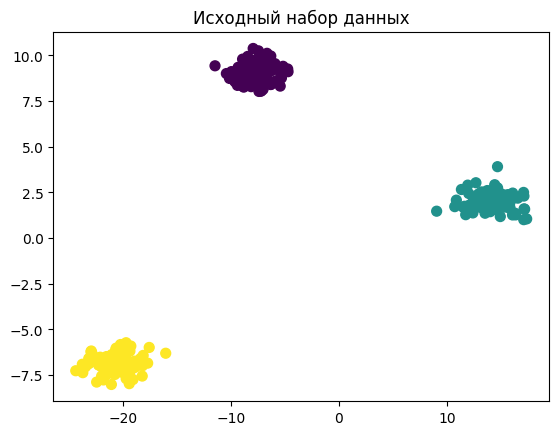

| Метрика | Стандартизация | Силуэтный коэффициент | Inertia |
|---------|----------------|----------------------|---------|
| euclidean | True | 0.924 | 34.188 |
| euclidean | False | 0.913 | 397.392 |
| manhattan | True | 0.929 | 43.526 |
| manhattan | False | 0.922 | 478.240 |
| cosine | True | 0.997 | 0.582 |
| cosine | False | 0.995 | 0.515 |


In [87]:
X, y = make_blobs(n_samples=300, centers=3, cluster_std=[0.5, 0.5, 0.5], random_state=42)
X[:, 0] = X[:, 0] * 3
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.title('Исходный набор данных')
plt.show()

def clara(X, metric, standardize):
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    model = CLARA(n_clusters=3, metric=metric, random_state=42)
    model.fit(X)
    labels = model.labels_
    inertia = model.inertia_
    
    from sklearn.metrics import silhouette_score
    silhouette = silhouette_score(X, labels, metric=metric)

    # plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
    # plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=200, alpha=0.5)
    # plt.title(f'Кластеризация методом clara с метрикой {metric} и стандартизацией {standardize}')
    # plt.show()
    return (silhouette, inertia)

metrics = ['euclidean', 'manhattan', 'cosine']
standardize = [True, False]
results = {} 
for m in metrics:
    for s in standardize:
        results[(m, s)] = clara(X, m, s)

print('| Метрика | Стандартизация | Силуэтный коэффициент | Inertia |')
print('|---------|----------------|----------------------|---------|')
for k, v in results.items():
    print(f'| {k[0]} | {k[1]} | {v[0]:.3f} | {v[1]:.3f} |')


# 3
Постройте дендрограмму для набора данных votes.repub в пакете «cluster» (число голосов, поданных за республиканцев на выборах с 1856 по 1976 год). Строки представляют 50 штатов, а столбцы -  годы выборов (31). Проинтерпретируйте полученный результат.

In [207]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [224]:
data = pd.read_csv('votes.repub.csv')
data.head()

,rownames,X1856,X1860,X1864,X1868,X1872,X1876,X1880,X1884,X1888,...,X1940,X1944,X1948,X1952,X1956,X1960,X1964,X1968,X1972,X1976
0,Alabama,NaN,NaN,NaN,51.44,53.19,40.02,36.98,38.44,32.28,...,14.34,18.20,19.04,35.02,39.39,41.75,69.5,14.0,72.4,43.48
1,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,50.94,34.1,45.3,58.1,62.91
2,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.01,40.90,43.82,58.35,60.99,55.52,50.4,54.8,64.7,58.62
3,Arkansas,NaN,NaN,NaN,53.73,52.17,39.88,39.55,40.50,38.07,...,20.87,29.84,21.02,43.76,45.82,43.06,43.9,30.8,68.9,34.97
4,California,18.77,32.96,58.63,50.24,56.38,50.88,48.92,52.08,49.95,...,41.35,42.99,47.14,56.39,55.40,50.10,40.9,47.8,55.0,50.89


In [225]:
for column in data:
    print(column, ": ", data[column].isna().sum())

rownames :  0
X1856 :  30
X1860 :  27
X1864 :  25
X1868 :  17
X1872 :  13
X1876 :  13
X1880 :  12
X1884 :  12
X1888 :  12
X1892 :  8
X1896 :  6
X1900 :  6
X1904 :  6
X1908 :  5
X1912 :  3
X1916 :  2
X1920 :  2
X1924 :  2
X1928 :  2
X1932 :  2
X1936 :  2
X1940 :  2
X1944 :  2
X1948 :  2
X1952 :  2
X1956 :  2
X1960 :  0
X1964 :  0
X1968 :  0
X1972 :  0
X1976 :  0


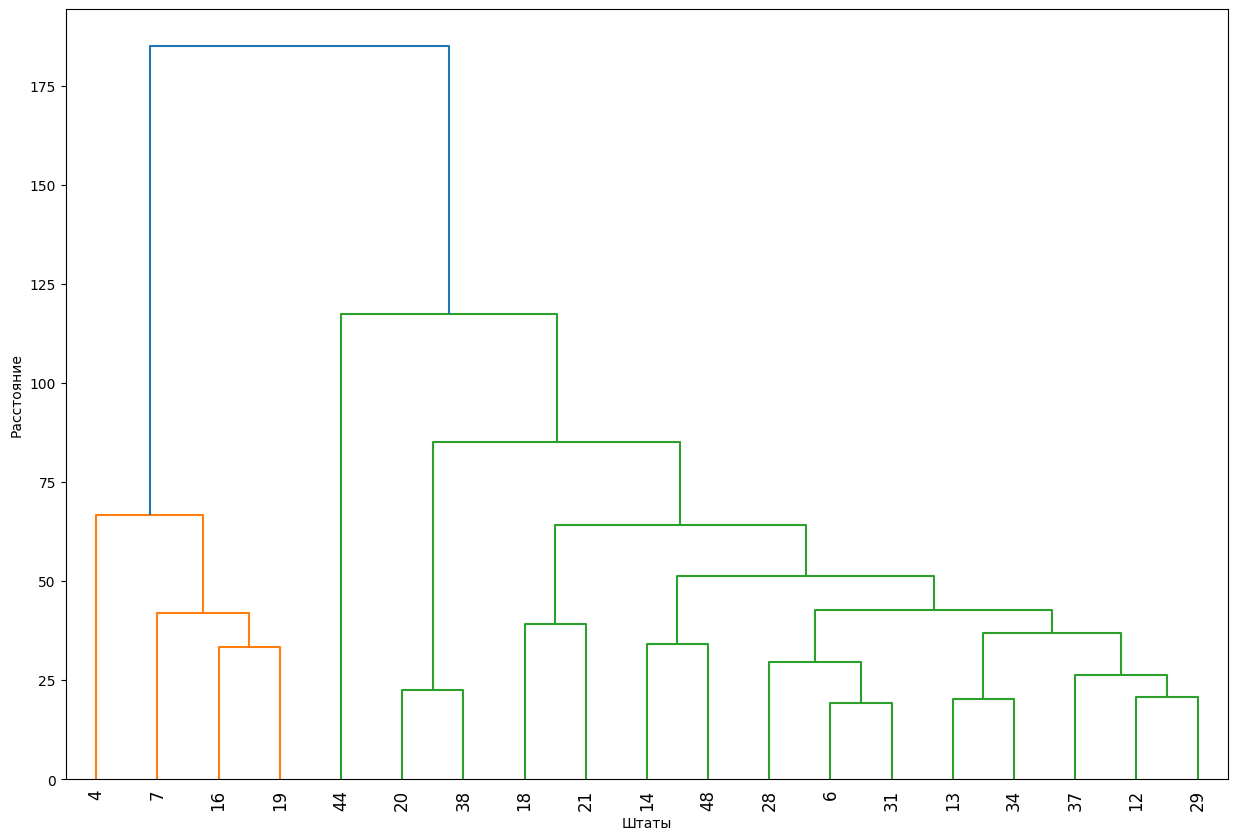

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

data = pd.read_csv('votes.repub.csv').dropna()
data = data.drop('rownames', axis=1)


X = data.to_numpy()

Z = linkage(X, method='ward')

plt.figure(figsize=(15, 10))
#plt.title('Дендрограмма для набора данных votes.repub')
plt.xlabel('Штаты')
plt.ylabel('Расстояние')
dendrogram(Z, labels=data.index, leaf_rotation=90)
plt.savefig('votes_dendro.png', dpi=300)
plt.show()


# 4	
Постройте дендрограмму для набора данных animals в пакете «cluster». Данные содержат 6 двоичных признаков для 20 животных. Переменные - [ , 1] war теплокровные; [ , 2] fly летающие; [ , 3] ver позвоночные; [ , 4] end вымирающие; [ , 5] gro живущие в группе; [ , 6] hai имеющие волосяной покров. Проинтерпретируйте полученный результат.

In [226]:
data = pd.read_csv('animals.csv')
data = data.drop("rownames", axis=1)
data.head()

,war,fly,ver,end,gro,hai
0,1,1,1,1.0,2.0,1
1,1,2,1,1.0,2.0,2
2,2,1,2,1.0,1.0,2
3,1,1,1,1.0,1.0,2
4,2,1,2,2.0,2.0,2


In [227]:
data = data.dropna()

In [228]:
data.dtypes

war      int64
fly      int64
ver      int64
end    float64
gro    float64
hai      int64
dtype: object

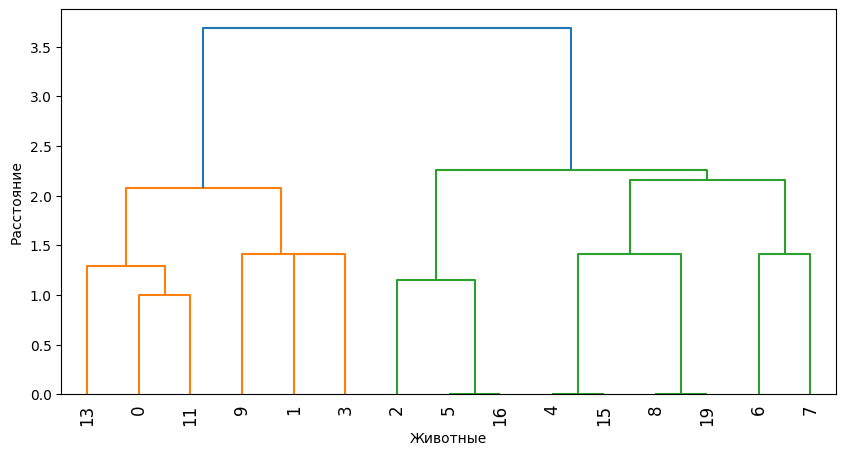

In [229]:
X = data.to_numpy()


Z = linkage(data, method='ward')

plt.figure(figsize=(10, 5))
#plt.title('Дендрограмма для набора данных animals')
plt.xlabel('Животные')
plt.ylabel('Расстояние')
dendrogram(Z, labels=data.index, leaf_rotation=90)
plt.savefig("animal_dendro.png")
plt.show()

# 5	
Рассмотрите данные из файла seeds_dataset.txt, который содержит описание зерен трех сортов пшеницы: Kama, Rosa and Canadian. Признаки: 1. область A, 2. периметр P, 3. компактность C = 4*pi*A/P^2, 4. длина зерна, 5. ширина зерна, 6. коэффициент ассиметрии, 7. длина колоска.

In [231]:
names = ["area A", "perimeter P", "compact", "seed len", "seed width", "sym coef", "spica len", 'sort']
data = pd.read_csv('seeds_dataset.txt', sep="\t", names=names)
data.head()

,area A,perimeter P,compact,seed len,seed width,sym coef,spica len,sort
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [232]:
for column in data:
    print(column, ": ", data[column].isnull().sum())

area A :  0
perimeter P :  0
compact :  0
seed len :  0
seed width :  0
sym coef :  0
spica len :  0
sort :  0


inertia: 430.6589731513007
Homogeneity: 0.728
0.5016348445511314


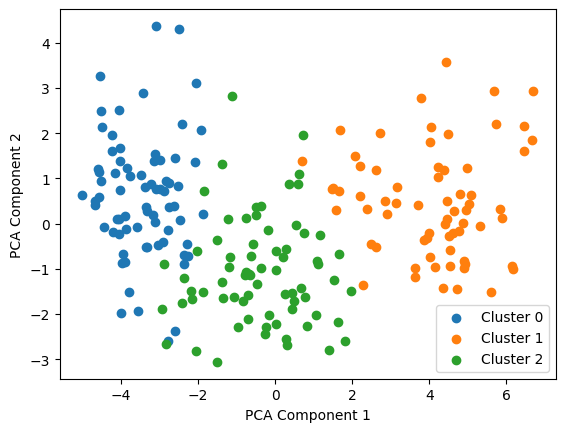

In [252]:
X = data.drop("sort", axis=1)
X = StandardScaler().fit_transform(X)
kmeans = KMeans(n_clusters=3)
labels_true = data['sort']
kmeans.fit(X)
labels = kmeans.labels_
print("inertia:", kmeans.inertia_)
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(silhouette_score(X, kmeans.labels_))
data['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data.drop(columns=['cluster', 'sort']))
for cluster in range(3):
    cluster_data = reduced_data[data['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.savefig("pca_seeds.png", dpi = 300)
plt.show()


In [253]:
db = DBSCAN().fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 205


In [247]:
import sklearn.metrics as metrics

In [250]:

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Homogeneity: 0.024
Silhouette Coefficient: 0.062
